Author: Sigrid Bom Nielsen

Created in May, 2024

# 2. Embedding text variables

Objectives of script:
- Embedding the different preprocessed text colummns; 'Country', 'Occupation' and 'Short descriptions' using a pretrained transformer model (SBERT)
    - This will be done separately for the training, validation and test datasets to ease computation
- Reducing the dimensionality of the embeddings using PCA
- Clustering some of the embeddings to see if we can do feature engineering
- Concatenating the dimensionality reduced PCA vectors of text embeddings, so that we have are ready to go in the next script.

Modelled are saved throughout the script when they take more than a minute to run.

In [ ]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from collections import Counter
import wordcloud
from sklearn.metrics import silhouette_score
import umap.umap_ as umap

In [2]:
# load train, val and test set (all text columns have to be embedded)
train = pd.read_csv('/work/datascience_exam/data/train.csv', index_col=0)
val = pd.read_csv('/work/datascience_exam/data/val.csv', index_col=0)
test = pd.read_csv('/work/datascience_exam/data/test.csv', index_col=0)


In [8]:
# get the features from each dataset
X_train = train.iloc[:,:5]
X_val = val.iloc[:,:5]
X_test = test.iloc[:,:5]

# y-values - to be saved later with the embedded features 
y_train = train.iloc[:,5]
y_val = val.iloc[:,5]
y_test = test.iloc[:,5]

## Embedding 'Country' using sbert 

In [10]:
# get model
model_sbert = SentenceTransformer("all-MiniLM-L6-v2")


/work/datascience_exam/env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
# sentences need to be in list format 
country_train = X_train.loc[:,'Country'].tolist()
# embed train country
country_embeddings_train = model_sbert.encode(country_train)

In [21]:
# val and test sets
# first make them to lists
country_val = X_val.loc[:,'Country'].tolist()
country_test = X_test.loc[:,'Country'].tolist()

# then make the embeddings
country_embeddings_val = model_sbert.encode(country_val)
country_embeddings_test = model_sbert.encode(country_test)

In [22]:
country_embeddings_train.shape # checking - we have the expected number of embeddings

(510302, 384)

### Reducing the dimensionalities of 'Country' embeddings

In [23]:
# first, we instantiate the PCA
pca = PCA(n_components= 250, random_state=42)

# then we fit the PCA to the training data
pca_vecs = pca.fit_transform(country_embeddings_train)

# calculate cumulative explained variance for plotting
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

In [24]:
threshold = 0.95 # threshold of variance to be explained 
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components needed to explain {threshold*100}% variance: {num_components}")

Number of components needed to explain 95.0% variance: 35


Magic number of components is 35.

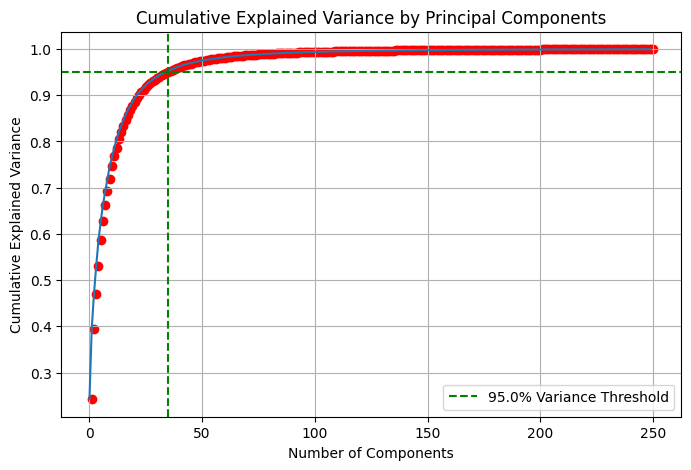

In [25]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance)
plt.scatter(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='r')
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold*100}% Variance Threshold')
plt.axvline(x=num_components, color='g', linestyle='--')

# Adding labels and title
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.legend()
plt.show()

In [26]:
# instantiate the PCA with the specified number of components
pca = PCA(n_components=35, random_state=42) 

# fit PCA and transform training data
pca_vecs_country_train = pca.fit_transform(country_embeddings_train) # fit to training

# transform val and test data using the PCA which was fitted to the training data
pca_vecs_country_val = pca.transform(country_embeddings_val)
pca_vecs_country_test = pca.transform(country_embeddings_test) 

# stack data frames
#X_train_country_pca = np.hstack((X_train, pca_vecs_country_train)) # do I need this dataframe? 
#X_val_country_pca = np.hstack((X_val, pca_vecs_country_val)) 
#X_test_country_pca = np.hstack((X_test, pca_vecs_country_test))


In [27]:
# save vectors in case of code crashing
np.save("/work/datascience_exam/data/pca_vecs_country_train", pca_vecs_country_train)
np.save("/work/datascience_exam/data/pca_vecs_country_val", pca_vecs_country_val)
np.save("/work/datascience_exam/data/pca_vecs_country_test", pca_vecs_country_test)

### Clustering 'Country' embeddings

In order to figure out how many clusters we should we make, we'll test a range of different clusters and see when the 'elbowpoint' occurs. That is, when adding another cluster doesn't make a great difference in inertia. 

The goal is to find the lowest number of clusters with the lowest value of inertia.

/tmp/ipykernel_31677/3775845088.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', marker='o')


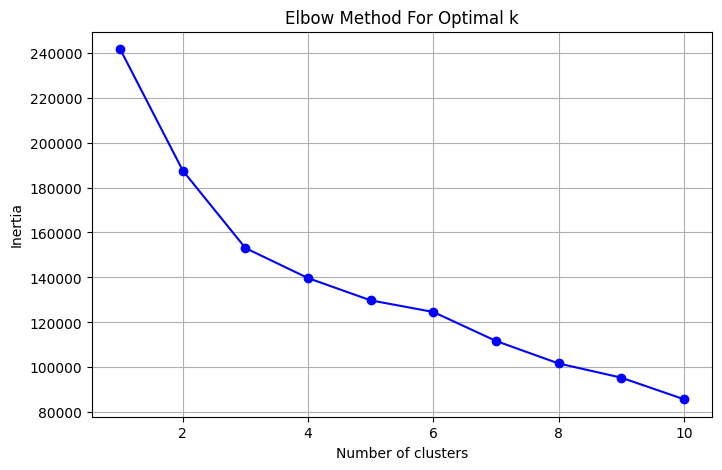

In [28]:
# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_vecs_country_train)
    inertia.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

7 or 8 clusters looks like the way to go. 

Another way of testing how many clusters to make is by a Silhouette analysis, which measures how similar a data point is to its cluster compared to other clusters. 

Before I run the Silhouette analysis, I'll subset the data to ease computation.

In [29]:
# take a subset of the data
embed_subset = pca_vecs_country_train[:10000,:]
embed_subset.shape


(10000, 35)

/tmp/ipykernel_31677/2620205839.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, silhouette_avg, 'bo-', marker='o')


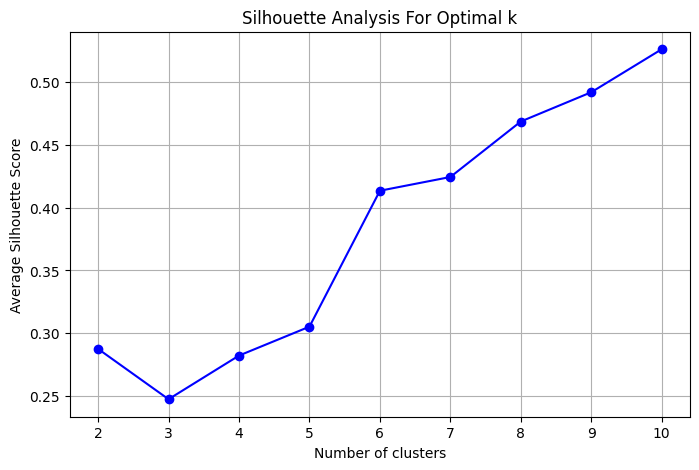

In [30]:
# Silhouette Analysis to find the optimal number of clusters
silhouette_avg = []
K = range(2, 11)  # Silhouette score is not defined for k=1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embed_subset)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(embed_subset, cluster_labels))

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_avg, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.grid(True)
plt.show()

Given that this is only a subset of the data, We'll go for 7 clusters. 

Below is a function which clusters embeddings and appends the clusters to the dataframe which contains the text value which has been embedded - so we can plot the clusters afterwards.

To be able to use the function for both 'Country' and 'Occupation', the function has an argument which takes the name of the new cluster column.

In [31]:
def clustering(embedded_data, n_clusters, X_train_data, cluster_name):
    X_train_w_country_clusters_temp = []

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embedded_data)

    clusters = kmeans.labels_
    clusters_pd = pd.DataFrame(clusters, columns = [cluster_name])
    X_train_w_country_clusters_temp = pd.concat([X_train_data, clusters_pd], axis = 1)

    return(X_train_w_country_clusters_temp)


In [32]:
# call function
X_train_w_country_clusters = clustering(pca_vecs_country_train, 7, X_train, 'Country_cluster') 

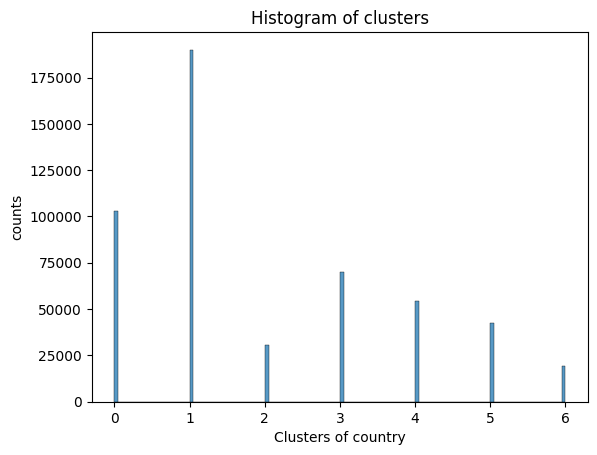

In [33]:
# plotting the distribution of the clusters 
sns.histplot(X_train_w_country_clusters.loc[:,'Country_cluster'])
plt.xlabel('Clusters of country')
plt.ylabel('counts')
plt.title('Histogram of clusters')
plt.show()

The clusters are not perfectly balanced.

Let's see what they contain by making some wordclouds.

The wordcloud function takes the dataframe with the cluster column, the number of the cluster which we want to plot and the name of the feature which we want to plot.

In [34]:
# Wordcloud function

def wordcloud_of_cluster(clustered_data, cluster_no, feature):

    # filter cluster no
    if feature == 'Country':
        cluster = clustered_data[clustered_data.loc[:, 'Country_cluster'] == cluster_no]
    if feature == 'Occupation':
        cluster = clustered_data[clustered_data.loc[:, 'Occupation_cluster'] == cluster_no]
    
    cluster_pd = pd.DataFrame(cluster, columns=['idx', 'Country', 'Occupation', 'cluster_no'])
    word_list = [word.strip() for sublist in cluster_pd[feature].str.split(';') for word in sublist]
    count = Counter(word_list)

    return(count)

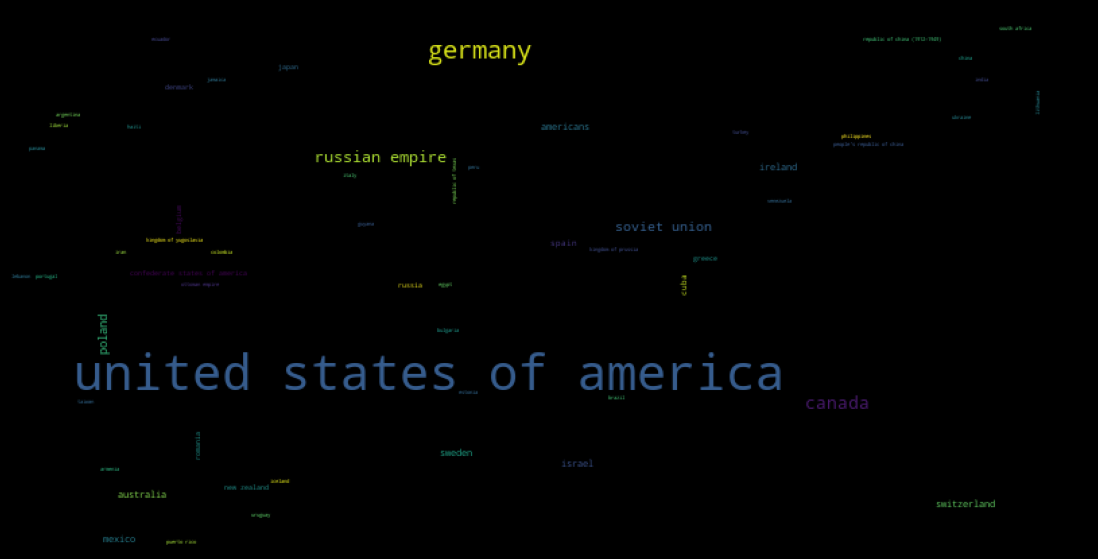

[('united states of america', 102934),
 ('germany', 533),
 ('canada', 217),
 ('russian empire', 180),
 ('soviet union', 127),
 ('poland', 106),
 ('ireland', 59),
 ('switzerland', 57),
 ('sweden', 52),
 ('americans', 48),
 ('australia', 45),
 ('israel', 45),
 ('mexico', 42),
 ('spain', 36),
 ('cuba', 36),
 ('confederate states of america', 29),
 ('denmark', 28),
 ('russia', 23),
 ('greece', 21),
 ('japan', 21)]

In [35]:
count = wordcloud_of_cluster(X_train_w_country_clusters, 0, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

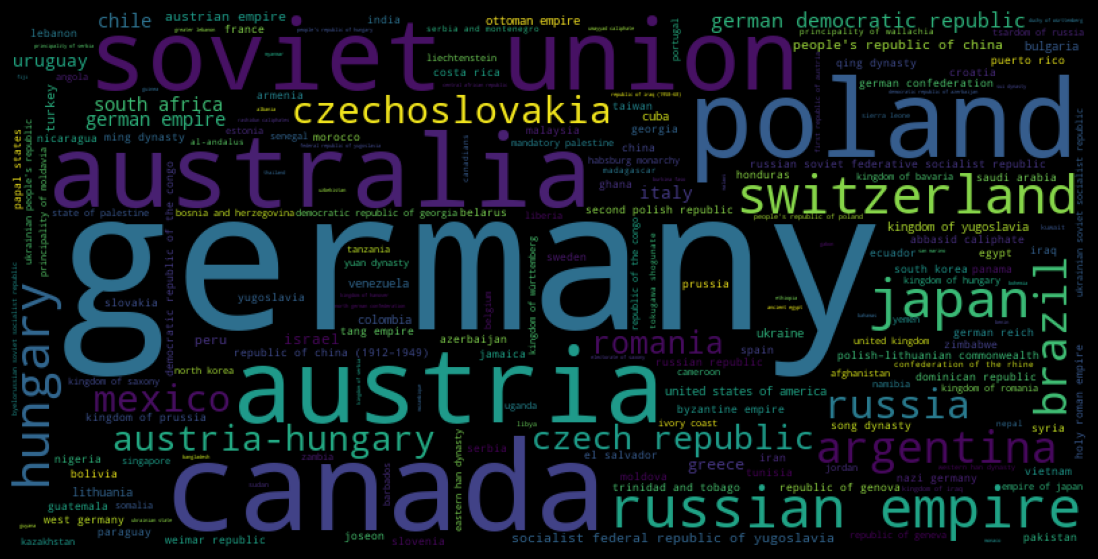

[('germany', 58149),
 ('canada', 14917),
 ('poland', 10879),
 ('austria', 9829),
 ('australia', 9558),
 ('soviet union', 9082),
 ('russian empire', 7081),
 ('japan', 6552),
 ('switzerland', 6261),
 ('hungary', 5757),
 ('argentina', 4392),
 ('brazil', 4275),
 ('russia', 3389),
 ('czechoslovakia', 2950),
 ('mexico', 2944),
 ('austria-hungary', 2944),
 ('czech republic', 2662),
 ('romania', 2183),
 ('german democratic republic', 2027),
 ('south africa', 1890)]

In [36]:
count = wordcloud_of_cluster(X_train_w_country_clusters, 1, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

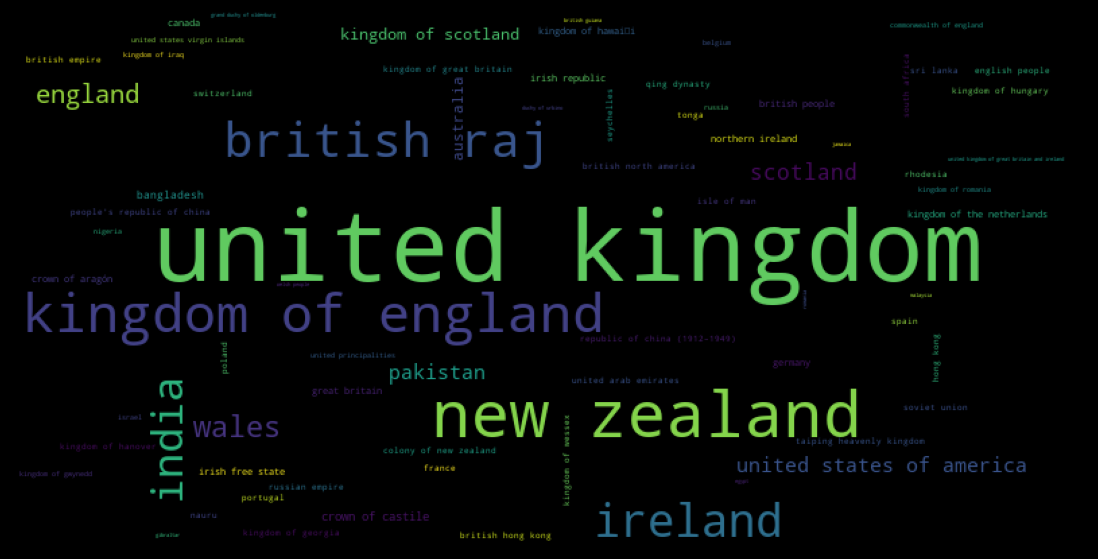

[('united kingdom', 15560),
 ('new zealand', 4808),
 ('kingdom of england', 3116),
 ('british raj', 2568),
 ('ireland', 2330),
 ('india', 2026),
 ('wales', 782),
 ('england', 594),
 ('scotland', 387),
 ('united states of america', 333),
 ('pakistan', 325),
 ('kingdom of scotland', 207),
 ('australia', 170),
 ('crown of castile', 123),
 ('bangladesh', 90),
 ('germany', 73),
 ('irish free state', 68),
 ('canada', 63),
 ('crown of aragón', 62),
 ('british people', 61)]

In [37]:
count = wordcloud_of_cluster(X_train_w_country_clusters, 2, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

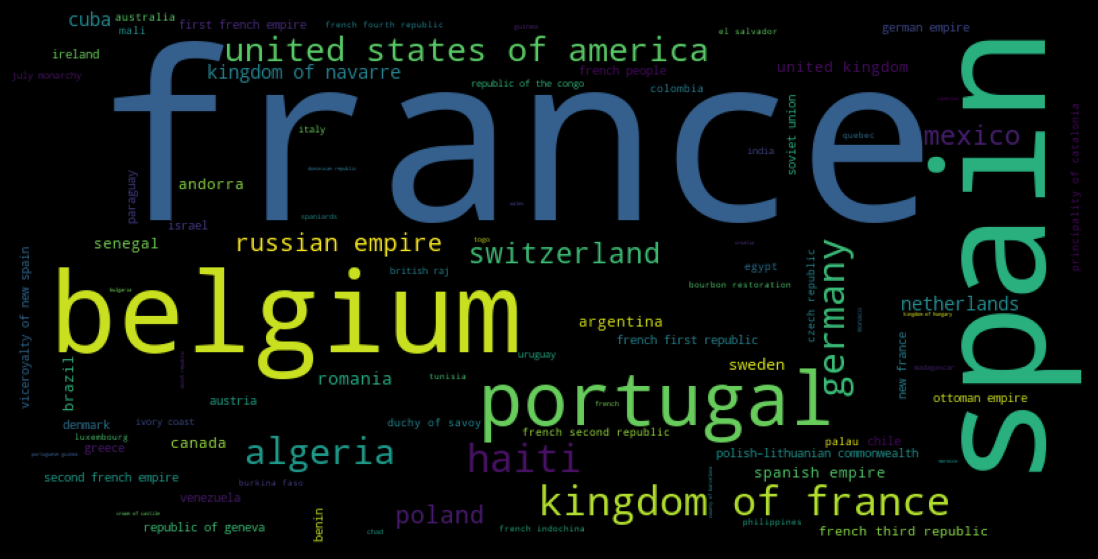

[('france', 46005),
 ('spain', 14494),
 ('belgium', 6936),
 ('portugal', 2205),
 ('kingdom of france', 212),
 ('haiti', 198),
 ('germany', 187),
 ('algeria', 172),
 ('united states of america', 152),
 ('switzerland', 105),
 ('mexico', 98),
 ('russian empire', 78),
 ('poland', 77),
 ('cuba', 40),
 ('netherlands', 39),
 ('kingdom of navarre', 39),
 ('romania', 35),
 ('sweden', 32),
 ('canada', 28),
 ('spanish empire', 27)]

In [38]:
count = wordcloud_of_cluster(X_train_w_country_clusters, 3, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

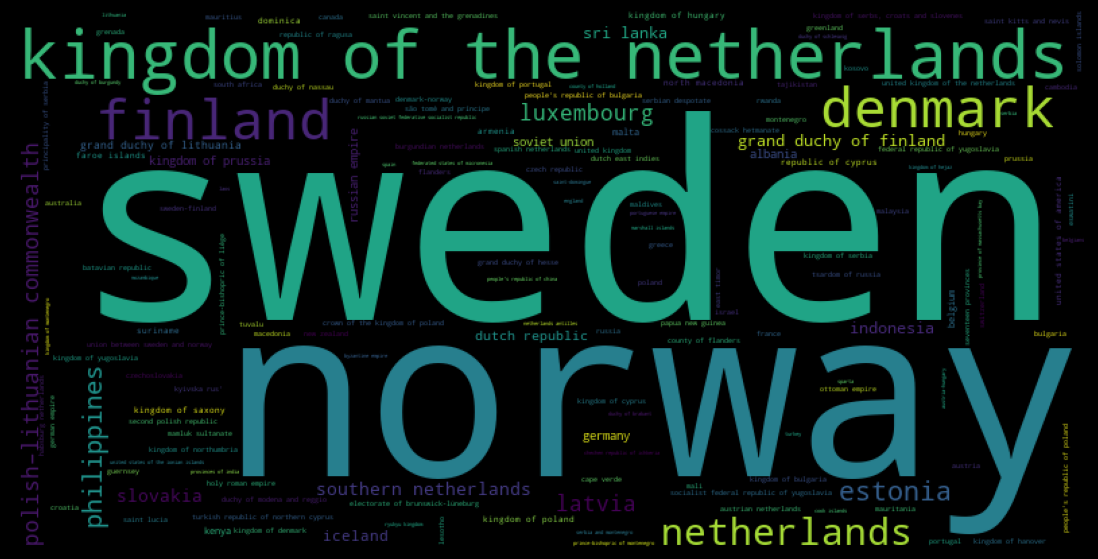

[('sweden', 13198),
 ('norway', 9698),
 ('kingdom of the netherlands', 9545),
 ('finland', 6034),
 ('denmark', 6027),
 ('netherlands', 2324),
 ('estonia', 989),
 ('philippines', 849),
 ('polish–lithuanian commonwealth', 625),
 ('latvia', 586),
 ('luxembourg', 585),
 ('slovakia', 387),
 ('southern netherlands', 372),
 ('indonesia', 322),
 ('grand duchy of finland', 319),
 ('sri lanka', 313),
 ('iceland', 286),
 ('dutch republic', 249),
 ('soviet union', 213),
 ('germany', 205)]

In [39]:
count = wordcloud_of_cluster(X_train_w_country_clusters, 4, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

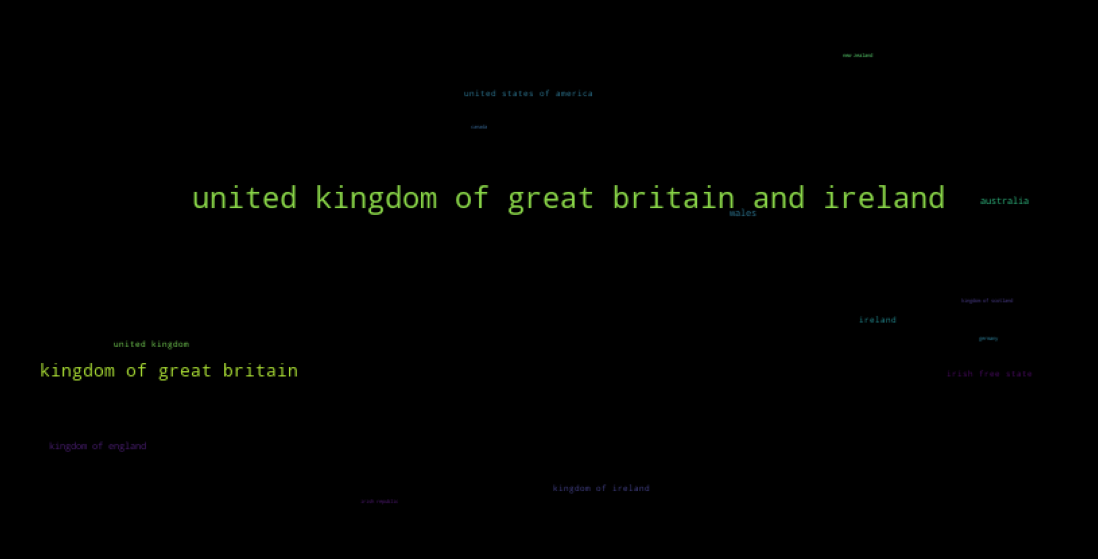

[('united kingdom of great britain and ireland', 38909),
 ('kingdom of great britain', 8391),
 ('wales', 544),
 ('australia', 513),
 ('kingdom of england', 509),
 ('ireland', 353),
 ('irish free state', 322),
 ('united kingdom', 313),
 ('united states of america', 264),
 ('kingdom of ireland', 226),
 ('canada', 75),
 ('kingdom of scotland', 66),
 ('irish republic', 62),
 ('germany', 62),
 ('new zealand', 59),
 ('france', 30),
 ('russian empire', 30),
 ('england', 25),
 ('south africa', 24),
 ('austria', 22)]

In [40]:
count = wordcloud_of_cluster(X_train_w_country_clusters, 5, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

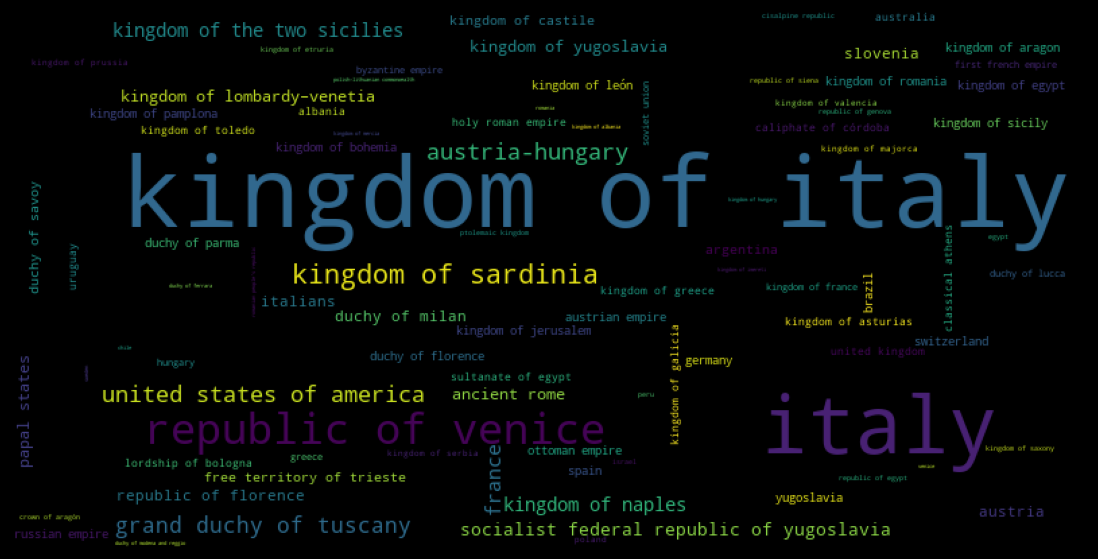

[('kingdom of italy', 17658),
 ('italy', 11079),
 ('republic of venice', 804),
 ('kingdom of sardinia', 202),
 ('austria-hungary', 144),
 ('united states of america', 142),
 ('grand duchy of tuscany', 118),
 ('france', 107),
 ('kingdom of naples', 86),
 ('kingdom of the two sicilies', 82),
 ('socialist federal republic of yugoslavia', 71),
 ('ancient rome', 65),
 ('papal states', 63),
 ('kingdom of lombardy–venetia', 61),
 ('kingdom of yugoslavia', 58),
 ('republic of florence', 50),
 ('italians', 47),
 ('duchy of milan', 45),
 ('austria', 45),
 ('slovenia', 42)]

In [41]:
count = wordcloud_of_cluster(X_train_w_country_clusters, 6, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

These clusters might not make a lot of sense in that some countries can be found in different wordclouds.

This is because the wordclouds count each individual string while the clusters are based on the data where some of the rows contain multiple strings for 'Country'.'

Also, the embeddings don't seem to capture the geographical aspects of the data - which is fair enough :-)

I won't use these clusters as a new feature in the dataset.

Now, we are continuing to embedding 'Occupation'.

## Embedding 'Occupation' using sbert sentencetransformer 

In [43]:
# choose model
#model_sbert = SentenceTransformer("all-MiniLM-L6-v2")
# model has already been loaded

In [42]:
# sentences need to be in list format 
occupation_train = X_train.loc[:,'Occupation'].tolist()

# embed train occupation
occupation_embeddings_train = model_sbert.encode(occupation_train)

In [43]:
# val and test sets
# first, save them as lists
occupation_val = X_val.loc[:,'Occupation'].tolist()
occupation_test = X_test.loc[:,'Occupation'].tolist()

# then make the embeddings
occupation_embeddings_val = model_sbert.encode(occupation_val)
occupation_embeddings_test = model_sbert.encode(occupation_test)

### Reducing the dimensionality of 'Occupation' embeddings

In [44]:
# instantiating PCA
pca = PCA(n_components= 250, random_state=42)

# fitting the PCA to the training data
pca_vecs = pca.fit_transform(occupation_embeddings_train)

# calculating the cumulative variance for plotting
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

In [45]:
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components needed to explain {threshold*100}% variance: {num_components}")

Number of components needed to explain 95.0% variance: 47


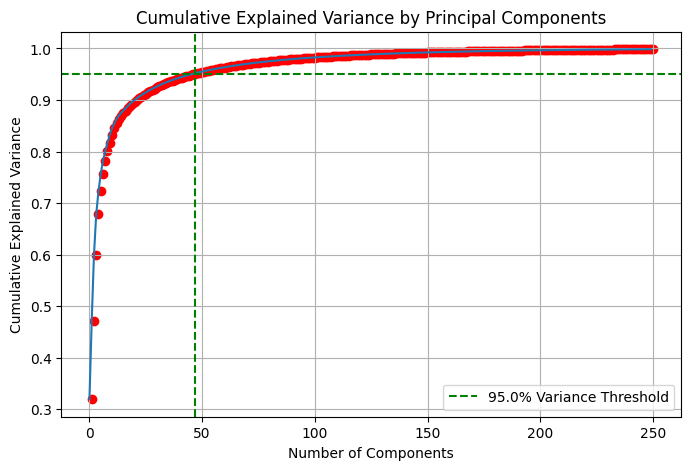

In [46]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance)
plt.scatter(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='r')
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold*100}% Variance Threshold')
plt.axvline(x=num_components, color='g', linestyle='--')

# Adding labels and title
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.legend()
plt.show()

We'll reduce the 'Occupation' embeddings to 47 to reach the threshold of 95% of variance in the data.

In [47]:
# instantiating PCA with the specificed number of components
pca = PCA(n_components=47, random_state=42) 

# fit PCA and transform training data
pca_vecs_occupation_train = pca.fit_transform(occupation_embeddings_train) 

# transform val and test data using the PCA which was fitted to the training data
pca_vecs_occupation_val = pca.transform(occupation_embeddings_val)
pca_vecs_occupation_test = pca.transform(occupation_embeddings_test) 

# stack data frames
#X_train_occupation_pca = np.hstack((X_train, pca_vecs_occupation_train))
#X_val_occupation_pca = np.hstack((X_val, pca_vecs_occupation_val))
#X_test_occupation_pca = np.hstack((X_test, pca_vecs_occupation_test))

In [48]:
# save vectors in case of code crashing
np.save("/work/datascience_exam/data/pca_vecs_occupation_train", pca_vecs_occupation_train)
np.save("/work/datascience_exam/data/pca_vecs_occupation_val", pca_vecs_occupation_val)
np.save("/work/datascience_exam/data/pca_vecs_occupation_test", pca_vecs_occupation_test)

### Clustering 'Occupation'

/tmp/ipykernel_31677/2195224418.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', marker='o')


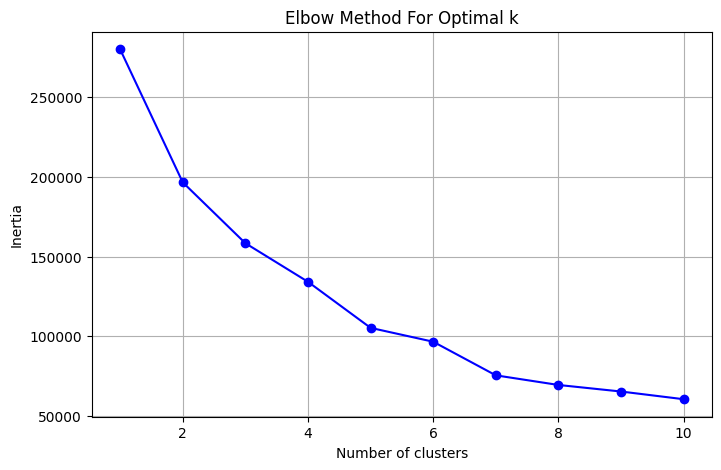

In [49]:
# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(occupation_embeddings_train)
    inertia.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

6-8 clusters. We'll calculate silhouette scores on a subset of the data.

In [50]:
# sample dataset (or reduce number of rows for testing code)
embed_subset = occupation_embeddings_train[:10000,:]


/tmp/ipykernel_31677/3235048406.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, silhouette_avg, 'bo-', marker='o')


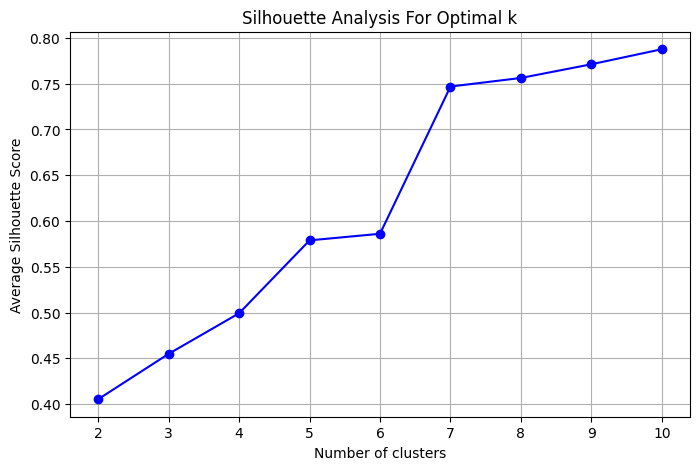

In [51]:
# Silhouette Analysis to find the optimal number of clusters
silhouette_avg = []
K = range(2, 11)  # Silhouette score is not defined for k=1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embed_subset)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(embed_subset, cluster_labels))

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_avg, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.grid(True)
plt.show()


Initially, I ran the code with 7 clusters, but very few embeddings where in the 5th and the 6th cluster.

So, I'll rerun the code with 6 clusters.

In [52]:
X_train_w_occupation_clusters = clustering(occupation_embeddings_train, 6, X_train, 'Occupation_cluster') 
X_train_w_occupation_clusters.shape

(510302, 6)

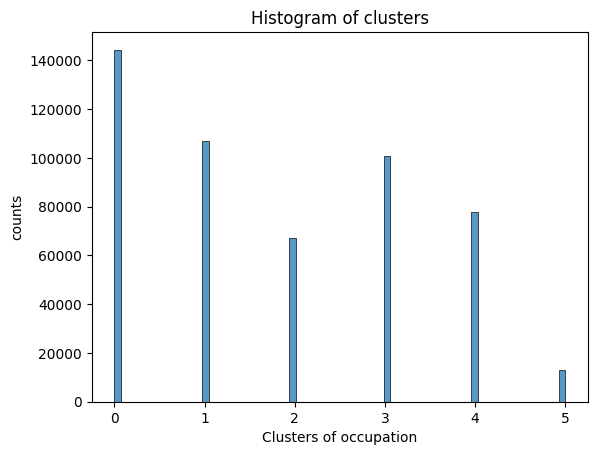

In [53]:
sns.histplot(X_train_w_occupation_clusters.loc[:,'Occupation_cluster'])
plt.xlabel('Clusters of occupation')
plt.ylabel('counts')
plt.title('Histogram of clusters')
plt.show()

Make wordclouds with the function defined earlier.

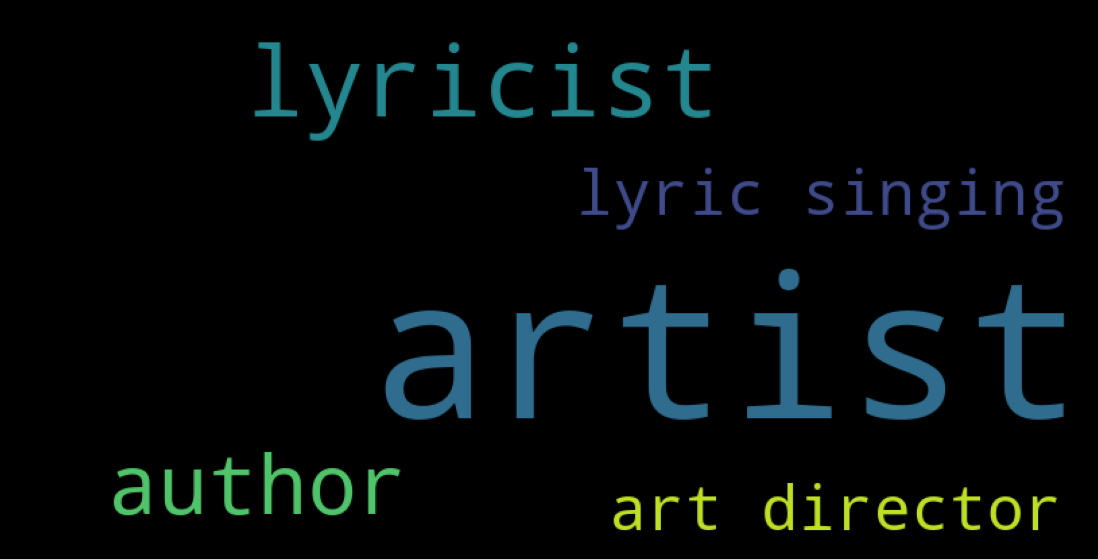

[('artist', 144405),
 ('lyricist', 3),
 ('author', 2),
 ('lyric singing', 1),
 ('art director', 1)]

In [54]:
count = wordcloud_of_cluster(X_train_w_occupation_clusters, 0, 'Occupation')
wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)

plt.figure(figsize=(15,7), facecolor = 'k')
plt.imshow(wordcloud_temp)
plt.axis("off")
plt.show()
count.most_common(20)

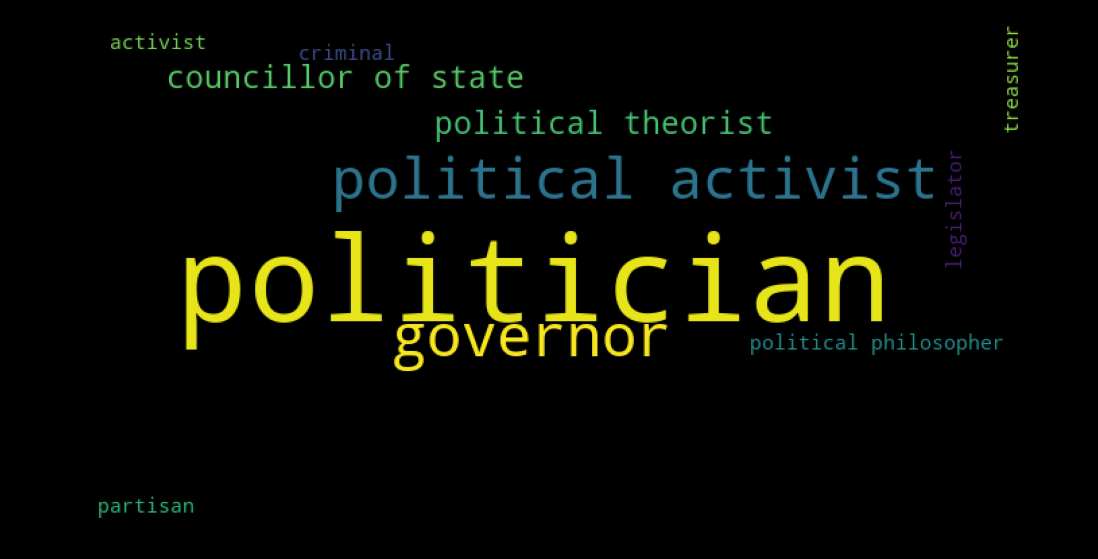

[('politician', 107064),
 ('governor', 28),
 ('political activist', 26),
 ('councillor of state', 3),
 ('political theorist', 3),
 ('legislator', 1),
 ('political philosopher', 1),
 ('partisan', 1),
 ('activist', 1),
 ('criminal', 1),
 ('treasurer', 1)]

In [55]:
count = wordcloud_of_cluster(X_train_w_occupation_clusters, 1, 'Occupation')
wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)

plt.figure(figsize=(15,7), facecolor = 'k')
plt.imshow(wordcloud_temp)
plt.axis("off")
plt.show()
count.most_common(20)

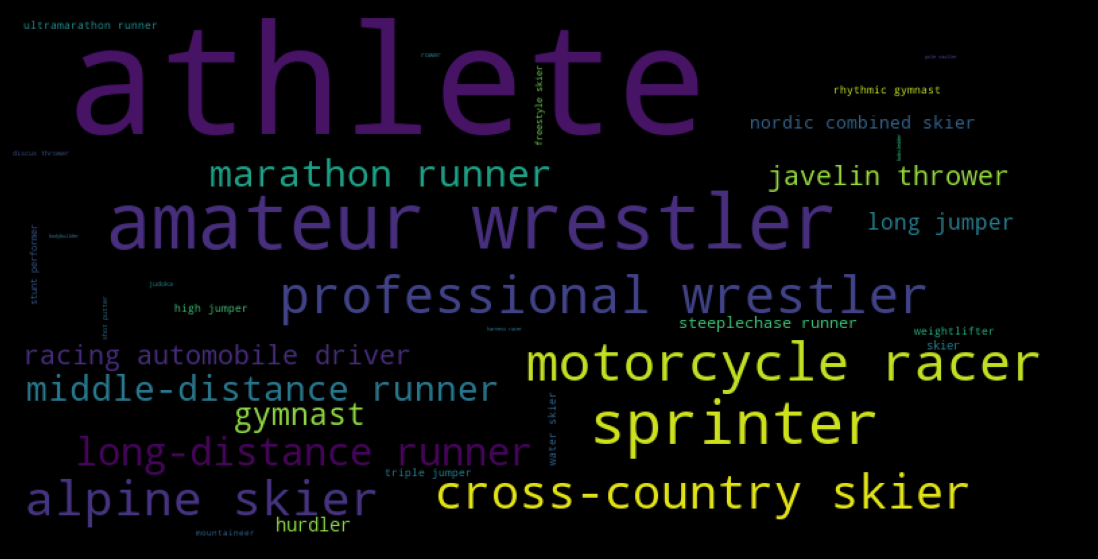

[('athlete', 64612),
 ('amateur wrestler', 667),
 ('sprinter', 376),
 ('motorcycle racer', 286),
 ('professional wrestler', 261),
 ('alpine skier', 230),
 ('cross-country skier', 223),
 ('long-distance runner', 142),
 ('marathon runner', 129),
 ('middle-distance runner', 107),
 ('gymnast', 83),
 ('racing automobile driver', 58),
 ('javelin thrower', 56),
 ('long jumper', 35),
 ('hurdler', 27),
 ('nordic combined skier', 24),
 ('steeplechase runner', 20),
 ('skier', 11),
 ('triple jumper', 9),
 ('ultramarathon runner', 8)]

In [56]:
count = wordcloud_of_cluster(X_train_w_occupation_clusters, 2, 'Occupation')
wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)

plt.figure(figsize=(15,7), facecolor = 'k')
plt.imshow(wordcloud_temp)
plt.axis("off")
plt.show()
count.most_common(20)

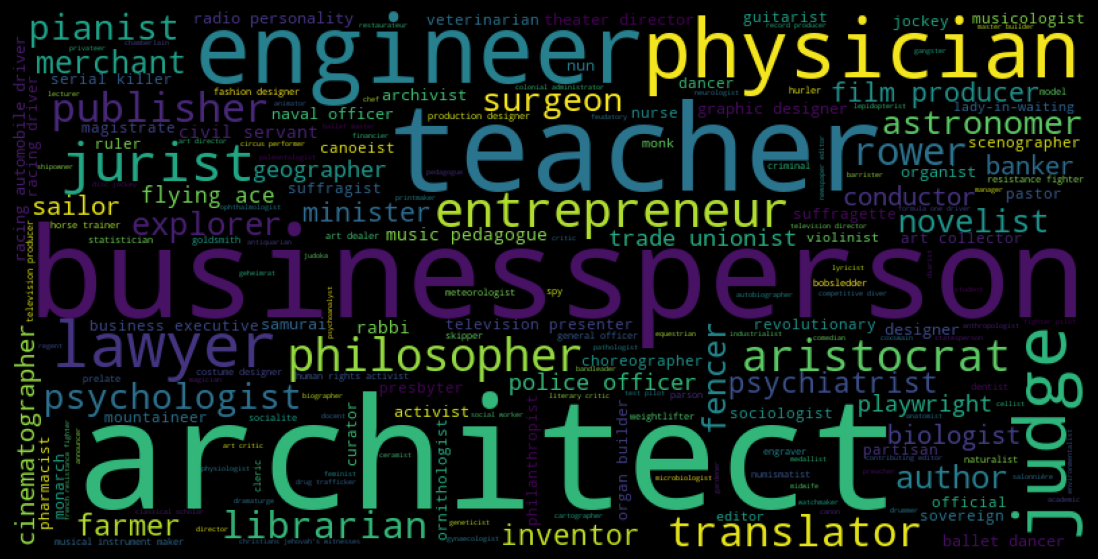

[('architect', 8695),
 ('businessperson', 8377),
 ('teacher', 7549),
 ('engineer', 5763),
 ('physician', 5250),
 ('judge', 3946),
 ('lawyer', 3105),
 ('jurist', 2120),
 ('entrepreneur', 1752),
 ('philosopher', 1443),
 ('aristocrat', 1378),
 ('translator', 1222),
 ('publisher', 1179),
 ('rower', 1133),
 ('librarian', 1038),
 ('psychologist', 977),
 ('pianist', 958),
 ('surgeon', 907),
 ('astronomer', 885),
 ('explorer', 842)]

In [57]:
count = wordcloud_of_cluster(X_train_w_occupation_clusters, 3, 'Occupation')
wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)

plt.figure(figsize=(15,7), facecolor = 'k')
plt.imshow(wordcloud_temp)
plt.axis("off")
plt.show()
count.most_common(20)

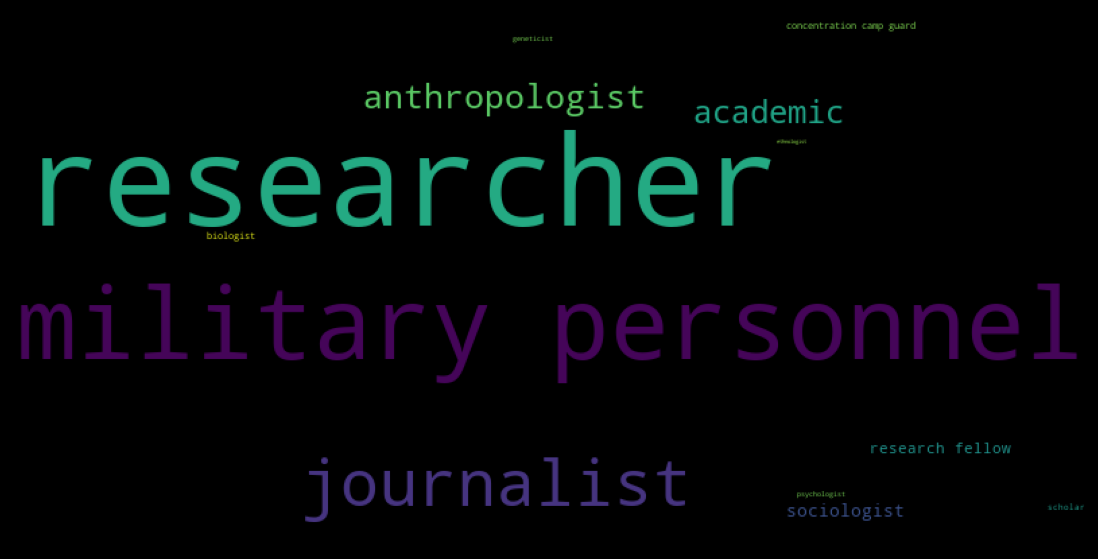

[('researcher', 44272),
 ('military personnel', 24962),
 ('journalist', 7528),
 ('anthropologist', 454),
 ('academic', 402),
 ('sociologist', 28),
 ('research fellow', 18),
 ('biologist', 5),
 ('concentration camp guard', 5),
 ('scholar', 4),
 ('geneticist', 3),
 ('psychologist', 3),
 ('ethnologist', 2),
 ('science communicator', 1),
 ('mycologist', 1),
 ('reporter', 1),
 ('meteorologist', 1),
 ('bibliographer', 1),
 ('microbiologist', 1),
 ('professeur des universités', 1)]

In [58]:
count = wordcloud_of_cluster(X_train_w_occupation_clusters, 4, 'Occupation')
wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)

plt.figure(figsize=(15,7), facecolor = 'k')
plt.imshow(wordcloud_temp)
plt.axis("off")
plt.show()
count.most_common(20)


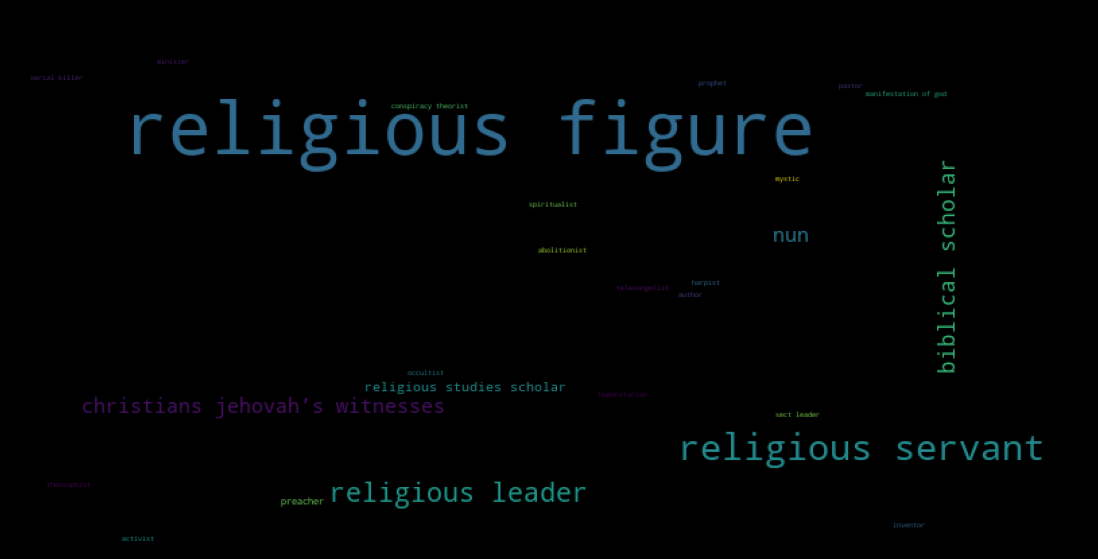

[('religious figure', 12963),
 ('religious servant', 84),
 ('religious leader', 38),
 ('biblical scholar', 23),
 ('nun', 19),
 ('christians jehovah’s witnesses', 19),
 ('religious studies scholar', 7),
 ('preacher', 3),
 ('harpist', 1),
 ('occultist', 1),
 ('humanitarian', 1),
 ('activist', 1),
 ('conspiracy theorist', 1),
 ('serial killer', 1),
 ('spiritualist', 1),
 ('theosophist', 1),
 ('author', 1),
 ('manifestation of god', 1),
 ('televangelist', 1),
 ('minister', 1)]

In [59]:
count = wordcloud_of_cluster(X_train_w_occupation_clusters, 5, 'Occupation')
wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)

plt.figure(figsize=(15,7), facecolor = 'k')
plt.imshow(wordcloud_temp)
plt.axis("off")
plt.show()
count.most_common(20)

These clusters look a lot better than the clusters made from the country embeddings, but they are still quite mixed. 

A review of the clusters:
- Cluster 0: Artist-related (the artist category is so big on its own that its carrying the cluster)
- Cluster 1: Politician-related
- Cluster 2: Sports-related
- Cluster 3: One big mix of many different occupations
- Cluster 4: A mix of research and military-related occupations.
- Cluster 5: Related to religion

I'll add the clusters as a feature in a dataframe.

So, I'll quickly cluster the validation and the test dataset using the same number of clusters.

In [60]:
X_val_w_occupation_clusters = clustering(occupation_embeddings_val, 6, X_val, 'Occupation_cluster') 
X_val_w_occupation_clusters.shape

(109351, 6)

In [61]:
X_test_w_occupation_clusters = clustering(occupation_embeddings_test, 6, X_test, 'Occupation_cluster') 
X_test_w_occupation_clusters.shape

(109351, 6)

### Making UMAP for visualization purposes with default params

UMAP can be used to reduce highly dimensional data. So, just to see what it might look like, we'll try to reduce the embeddings of 'Occupation' of the training data

In [ ]:
# setting a random seed turns of parallelization and subsequently takes much longer to run. So since this is just for visualization purposes, a random seet won't be set
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components = 2)#, random_state = 42) 
occupation_umap = umap_reducer.fit_transform(occupation_embeddings_train)

# save umap
occupation_umap_pd = pd.DataFrame(occupation_umap)
occupation_umap_pd.to_csv('/work/datascience_exam/data/occupation_umap_train.csv') 

In [62]:
# relooad umap UMAP 
occupation_umap = pd.read_csv('/work/datascience_exam/data/occupation_umap.csv', index_col=0)

In [63]:
# adding cluster no 
occupation_umap['cluster'] = X_train_w_occupation_clusters.loc[:,'Occupation_cluster']
occupation_umap.columns = ['feature1', 'feature2', 'cluster']
occupation_umap.head()

,feature1,feature2,cluster
0,3.173786,18.524569,1.0
1,-8.038143,8.851185,0.0
2,3.885321,-0.199881,0.0
3,-6.654826,8.743226,2.0
4,-7.285582,-13.047606,3.0


<Figure size 1000x600 with 0 Axes>

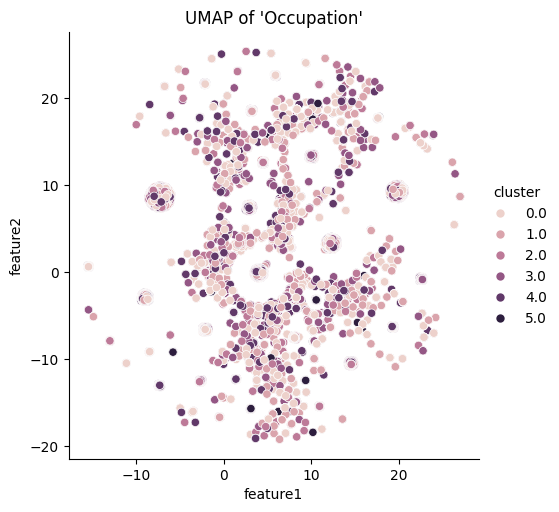

In [64]:
plt.figure(figsize = (10,6))#, constrained_layout = True)
sns.relplot(
    data = occupation_umap, 
    x = 'feature1', y = 'feature2',
    hue = 'cluster'
)

#plt.legend(loc = 'upper left')
plt.title("UMAP of 'Occupation'")#, y = 1.05)#, pad = 20)
#plt.tight_layout() # saves the title but messes up the legend
fig = plt.gcf()
plt.show()

In [65]:
fig.savefig('/work/datascience_exam/output/plots/UMAP_occupation2.jpg', dpi = 300)

The initial UMAP plot doesn't look too good. Even the clusters of the datapoints seem to contain different clusters.

To improve the plot, one should play around with the n_neighbors and min_dist parameters.

In the interest of time, I won't do that. 

Now we have embedded and reduced the components of 'Country' and 'Occupation'. We'll try to do the same with 'Short description'.

### Short description embeddings

Because the short descriptions consist of short sentences, I won't spend time to try to cluster the descriptions. 
They will only be embedded and reduced through PCA. 

In [11]:
# sentences need to be in list format 
description_train = X_train.loc[:,'Short description'].tolist()

# embed train description
description_embeddings_train = model_sbert.encode(description_train)

In [12]:
description_embeddings_train.shape

(510302, 384)

In [14]:
# val and test sets
# to list
description_val = X_val.loc[:,'Short description'].tolist()
description_test = X_test.loc[:,'Short description'].tolist()

# embeddings
description_embeddings_val = model_sbert.encode(description_val)
description_embeddings_test = model_sbert.encode(description_test)

### Reducing dimensionality of 'Short description' embeddings

In [15]:
# instantiating PCA
pca = PCA(n_components= 250, random_state=42)
# fitting PCA to the training data
pca_vecs = pca.fit_transform(description_embeddings_train)

#calculating cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

In [16]:
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components needed to explain {threshold*100}% variance: {num_components}")

Number of components needed to explain 95.0% variance: 152


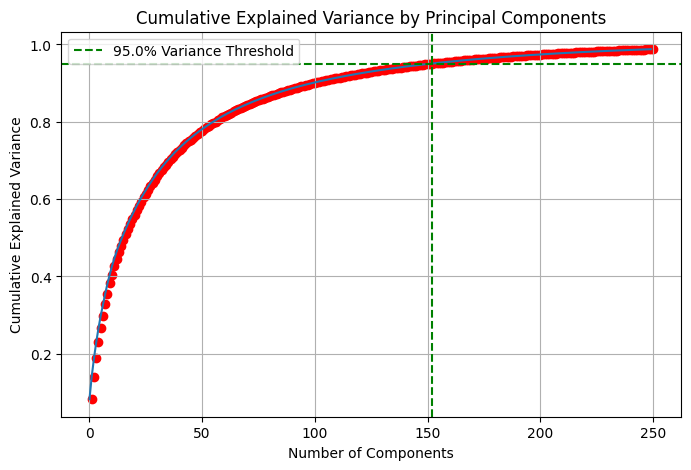

In [17]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance)
plt.scatter(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='r')
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold*100}% Variance Threshold')
plt.axvline(x=num_components, color='g', linestyle='--')

# Adding labels and title
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
# performing PCA with the specified number of components
pca = PCA(n_components=152, random_state=42) # instantiate PCA model

# fit PCA and transform training data
pca_vecs_description_train = pca.fit_transform(description_embeddings_train) # fit to training

# transform val and test data using the PCA which was fitted to the training data
pca_vecs_description_val = pca.transform(description_embeddings_val)
pca_vecs_description_test = pca.transform(description_embeddings_test) 

# stack data frames
#X_train_description_pca = np.hstack((X_train, pca_vecs_description_train))
#X_val_description_pca = np.hstack((X_val, pca_vecs_description_val))
#X_test_description_pca = np.hstack((X_test, pca_vecs_description_test))

In [19]:
# save vectors in case of code crashing
np.save("/work/datascience_exam/data/pca_vecs_description_train", pca_vecs_description_train)
np.save("/work/datascience_exam/data/pca_vecs_description_val", pca_vecs_description_val)
np.save("/work/datascience_exam/data/pca_vecs_description_test", pca_vecs_description_test)

## Saving embedded and reduced data in each data set

Now I'll concatenate the different pca vectors with the embeddings of the different text columns in their respective dataset (training, validation or test) so they are ready to be modelled. 

In [66]:
# Fixing colnames for the pca vectors - all country vecs have the same dimensions, so we only have to do this once
colnames_country = ['country' + str(i) for i in range(1,pca_vecs_country_train.shape[1]+1)]
colnames_occupation = ['occupation' + str(i) for i in range(1,pca_vecs_occupation_train.shape[1]+1)]
colnames_descriptions = ['description' + str(i) for i in range(1,pca_vecs_description_train.shape[1]+1)]

In [73]:
# Concatenating X_train
gender_birth_year = X_train.iloc[:,0:2]
occupation_cluster = X_train_w_occupation_clusters.loc[:, 'Occupation_cluster']

# make pca vecs to pd dataframe
country_pca_pd = pd.DataFrame(pca_vecs_country_train, columns=colnames_country)
occupation_pca_pd = pd.DataFrame(pca_vecs_occupation_train, columns = colnames_occupation)
description_pca_pd = pd.DataFrame(pca_vecs_description_train, columns = colnames_descriptions)

# and adding y back
train_features = pd.concat([gender_birth_year, occupation_cluster, country_pca_pd, occupation_pca_pd, description_pca_pd, y_train], axis = 1) 
train_features.shape

(510302, 238)

In [75]:
# Concatenating X_val
gender_birth_year = X_val.iloc[:,0:2]
occupation_cluster = X_val_w_occupation_clusters.loc[:, 'Occupation_cluster']

# make pca vecs to pd dataframe
country_pca_pd = pd.DataFrame(pca_vecs_country_val, columns=colnames_country)
occupation_pca_pd = pd.DataFrame(pca_vecs_occupation_val, columns = colnames_occupation)
description_pca_pd = pd.DataFrame(pca_vecs_description_val, columns = colnames_descriptions)

# and adding y back
val_features =pd.concat([gender_birth_year, occupation_cluster, country_pca_pd, occupation_pca_pd, description_pca_pd, y_val], axis = 1)  
val_features.shape

(109351, 238)

In [76]:
# Concatenating X_test
gender_birth_year = X_test.iloc[:,0:2]
occupation_cluster = X_test_w_occupation_clusters.loc[:, 'Occupation_cluster']

# make pca vecs to pd dataframe
country_pca_pd = pd.DataFrame(pca_vecs_country_test, columns=colnames_country)
occupation_pca_pd = pd.DataFrame(pca_vecs_occupation_test, columns = colnames_occupation)
description_pca_pd = pd.DataFrame(pca_vecs_description_test, columns = colnames_descriptions)

test_features = pd.concat([gender_birth_year, occupation_cluster, country_pca_pd, occupation_pca_pd, description_pca_pd, y_test], axis = 1)  
test_features.shape

(109351, 238)

Now we want to save all our hard work. 

In [77]:
train_features.to_csv('/work/datascience_exam/data/train_features.csv')
val_features.to_csv('/work/datascience_exam/data/val_features.csv')
test_features.to_csv('/work/datascience_exam/data/test_features.csv')

In [80]:
#testing = pd.read_csv('/work/datascience_exam/data/train_features.csv', index_col = 0)
#testing.shape

(510302, 238)